In [1]:
import glob
import matplotlib.image as mpimg
import numpy as np
from skimage.feature import hog
import cv2
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.measurements import label
import time 
from sklearn.externals import joblib
import pickle
from moviepy.editor import VideoFileClip
from IPython.display import HTML
# from skimage import measure
SEED = 2018
%matplotlib inline

# Feature extractor functions

In [2]:
def get_hog_features(img,orient,pix_per_cell,cell_per_block,vis=False,feature_vector=True):
    '''
    function:Extract HOG image and HOG features of a given image
    orient: number of bins for the orientation
    pix_per_cell: size of a cell
    cell_per_block: nber of cells per block
    vis(Boolean) :visualize the HOG image
    feature_vec(Boolean):return the features as a feature vector
    By default,the function uses transform_sqrt(apply power law compression to normalize the image before processing)
    '''
    if vis == True:
        features,hog_image = hog(img,orientations=orient,
                                pixels_per_cell=(pix_per_cell,pix_per_cell),
                                cells_per_block = (cell_per_block,cell_per_block),
                                transform_sqrt=True,
                                visualise=vis,feature_vector=feature_vector)
        return features,hog_image
    else:
        features = hog(img,orientations=orient,
                       pixels_per_cell=(pix_per_cell,pix_per_cell),
                      cells_per_block=(cell_per_block,cell_per_block),
                      transform_sqrt=True,
                      visualise=vis,feature_vector=feature_vector)
        return features

def bin_spatial(img,size=(32,32)):
    '''
    Binned Color Feature
    img:original image
    size:target size of the image
    output:feature vector
    '''
    features = cv2.resize(img,size).ravel()
    return features

def color_hist(img,nbins=32,bins_range=(0,256)):
    '''
    Color histogram features for each channel of the original image
    img: original image
    nbins: number of bins of the histogram
    output:concatenate feature vector
    '''
    channel1_hist = np.histogram(img[:,:,0],bins=nbins,range=bins_range)
    channel2_hist = np.histogram(img[:,:,1],bins=nbins,range=bins_range)
    channel3_hist = np.histogram(img[:,:,2],bins=nbins,range=bins_range)
    #Concatenate the histograms into a sigle feature vector
    hist_features = np.concatenate((channel1_hist[0],channel2_hist[0],channel3_hist[0]))
    # Return the individual histograms into a single feature vector 
    return hist_features

def color_cvt(img,cspace):
    '''
    image conversion to different color space
    cspace avaliable:'HSV','LUV','YUV','YCrCb'
    '''
    if cspace in ['HSV','LUV','HLS','YUV','YCrCb']:
        return cv2.cvtColor(img,eval('cv2.COLOR_RGB2'+cspace))
    else:
        return np.copy(img)

# Load SVC Classifier and Feature settings
这里选用svc分类器

In [3]:
data_file = 'model.p'
with open(data_file,mode='rb') as f:
    data = pickle.load(f)

svc = data['svc']
X_scaler = data['X_scaler']
color_space = data['color_space']
spatial_size = data['spatial_size']
hist_bins = data['hist_bins']
orient = data['orient']
pix_per_cell = data['pix_per_cell']
cell_per_block = data['cell_per_block']
hog_channel = data['hog_channel']
spatial_feat = data['spatial_feat']
hist_feat = data['hist_feat']
hog_feat = data['hog_feat']

# Smoothing 


In [4]:
# 此处列表的更新，可以使用固定长的队列存储，这里是固定更新的
class Buffer():
    def __init__(self,buffer_sz):
        self.buffer_sz = buffer_sz
        self.hot_windows = []
        self.heat_mframe = []
        self.hotwindows_mframe = []
        self.nwindow_mframe = []
    
    def add_hotwindows(self,new_val):
        self.hot_windows.append(new_val)
    
    def update_hotwindows_historic(self,new_val):
        self.hotwindows_mframe.extend(new_val)
        self.nwindow_mframe.append(len(new_val))
        if len(self.nwindow_mframe) > self.buffer_sz:
            self.hotwindows_mframe = self.hotwindows_mframe[self.nwindow_mframe[0]:]
            self.nwindow_mframe = self.nwindow_mframe[-self.buffer_sz:]
    def update_heat_historic(self,new_heat):
        self.heat_mframe.append(new_heat)
        if len(self.heat_mframe) > self.buffer_sz:
            self.heat_mframe = self.heat_mframe[-self.buffer_sz:]
buffer = Buffer(buffer_sz=40)

接下来实现一个函数来提取特征及作出预测

In [5]:
def find_cars(img,ystart,ystop,cells_per_step,scale,svc,X_scale,cspace,orient,pix_per_cell,
             cell_per_block,spatial_feat,spatial_size,hist_feat,hist_bins):
    '''
    uses a single HOG feature extraction on the entire image
    sliding_window = {'scale':[0.6, 0.8, 1.2, 1.6, 2, 2.2], 
          'ystart':[400, 400, 400, 350, 350, 350], 
          'ystop': [520, 520, 620, 620, 656, 656], 
          'cells_per_step': [3, 3, 1, 1, 1, 1]}
    img.shape: (720,1280,3)
    '''
    draw_img = np.copy(img)
    #Normalize pixel intensity
    img = img.astype(np.float32)/255
    #确定搜索车辆的区域
    img_tosearch = img[ystart:ystop,700::]
    #print(img_tosearch.shape)
    ctrans_tosearch = color_cvt(img_tosearch,cspace=cspace)
    if scale!=1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch,(np.int(imshape[1]/scale),np.int(imshape[0]/scale)))
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    #print(ch1.shape[1])
    # Define blocks and steps as above(//地板除法，取整数)
    nxblocks = (ch1.shape[1]//(pix_per_cell))-1
    nyblocks = (ch1.shape[0]//(pix_per_cell))-1
    #nfeat_per_block = orient*cell_per_block**2
    #64 was the original sampling rate with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window//(pix_per_cell))-1
    #cells_per_step = 2 instead of overlap ,define how many cells to step cells=>block
    nxsteps = (nxblocks-nblocks_per_window)//cells_per_step
    nysteps = (nyblocks-nblocks_per_window)//cells_per_step
    #print('nxsteps:{},nysteps:{}'.format(nxsteps,nysteps))
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1,orient,pix_per_cell,cell_per_block,feature_vector=False)
    hog2 = get_hog_features(ch2,orient,pix_per_cell,cell_per_block,feature_vector=False)
    hog3 = get_hog_features(ch3,orient,pix_per_cell,cell_per_block,feature_vector=False)
    current_hot_windows = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            #Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window,xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window,xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window,xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1,hog_feat2,hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            #Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window,xleft:xleft+window],(64,64))
            #Get color features
            if spatial_feat == True:
                spatial_features = bin_spatial(subimg,size=spatial_size)
            if hist_feat == True:
                hist_features = color_hist(subimg,nbins=hist_bins)
            
            #Scale features and make a prediction
            if (spatial_feat== True) and (hist_feat==True) and (hog_feat==True):
                test_feature = X_scaler.transform(np.hstack((spatial_features,hist_features,
                                                             hog_features)).reshape(1,-1))
            elif (spatial_feat==True) and (hist_feat==False) and (hog_feat==True):
                test_features = X_scaler.transform(np.hstack((spatial_features,hog_features)).reshape(1,-1))
            
            test_prediction = svc.predict(test_features)
            if test_prediction ==1.:
                #这里scale系数需要还原
                xbox_left = np.int(xleft*scale) + 700
                ytop_draw = np.int(ytop*scale)+ystart
                win_draw = np.int(window*scale)
                buffer.add_hotwindows(((xbox_left,ytop_draw),(xbox_left+win_draw,ytop_draw+win_draw)))
                cv2.rectangle(draw_img,(xbox_left,ytop_draw),(xbox_left+win_draw,ytop_draw+win_draw),
                             (0,0,255),6)
    return draw_img

# Filters
前面代码中，我们将检测到汽车的位置存储在hot_windows中。通过hot_windows我们来画出热点图，并在热点图上应用阈值检测来清除错误检测的坐标

In [6]:
def add_heat(heatmap,bbox_list):
    '''
    iterate through list of positive sliding windows (bbox_list) and add heat
    
    '''
    for box in bbox_list:
        # Add +=1 for all pixels inside each bbox
        # Assuming each 'box' takes the form ((x1,y1),(x2,y2))
        heatmap[box[0][1]:box[1][1],box[0][0]:box[1][0]]+=1
    # return updated heatmap
    return heatmap# Iterate through

def apply_threshold(heatmap,threshold):
    '''
    Appy threshold on heatmap
    return thresholded heatmap where all values below threshold are set to 0
    '''
    # Zero out pixles below the threshold
    heatmap[heatmap<=threshold] = 0
    # return thresholded map
    return heatmap

def draw_labeled_bboxes(img,labels):
    #Iterate through all detected cars
    for car_number in range(1,labels[1]+1):
        #find pixels with each car_number label value
        nonzero = (labels[0]==car_number).nonzero()
        # Identify x and y values of those pixels
        nonezeroy = np.array(nonzero[0])
        nonezerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        
        bbox = ((np.min(nonezerox),np.min(nonezeroy)),(np.max(nonezerox),np.max(nonezeroy)))
        # Check car validtion ==> too small then ignore
        if(abs(bbox[0][0]-bbox[1][0])>50 and abs(bbox[0][1]-bbox[1][1])>50):#too small rect are ignore
            cv2.rectangle(img,bbox[0],bbox[1],(0,255,0),6)
    # return image
    return img

In [7]:
sliding_window = {'scale':[0.6, 0.8, 1.2, 1.6, 2, 2.2], 
          'ystart':[400, 400, 400, 350, 350, 350], 
          'ystop': [520, 520, 620, 620, 656, 656], 
          'cells_per_step': [3, 3, 1, 1, 1, 1]}

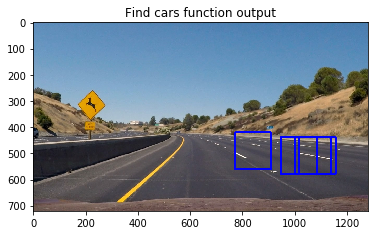

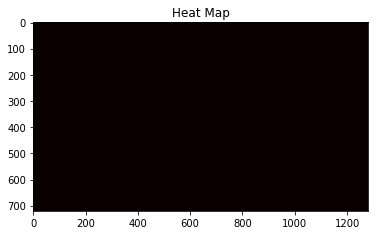

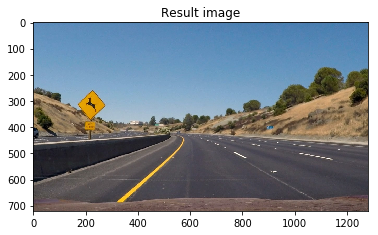

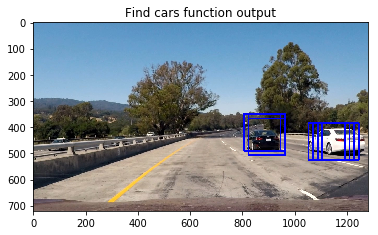

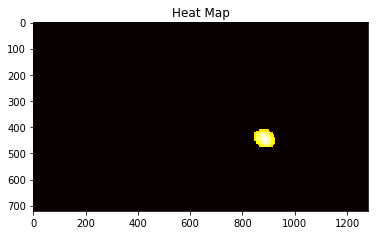

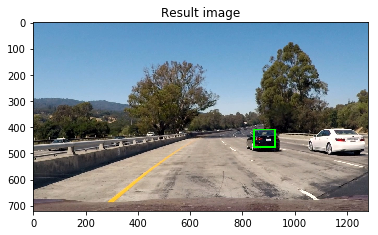

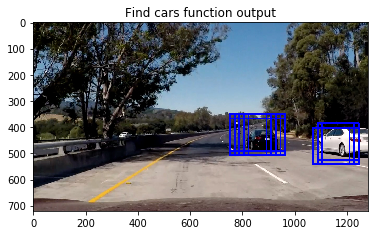

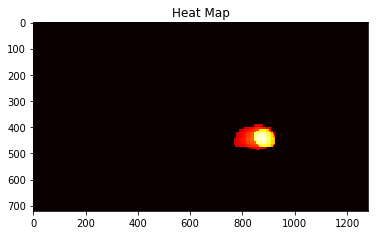

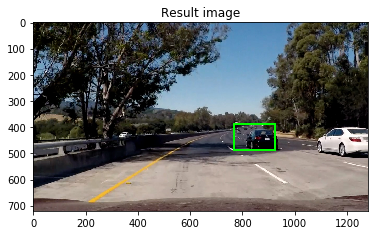

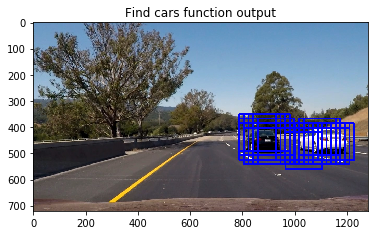

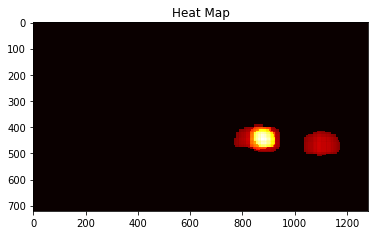

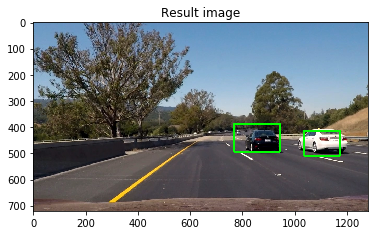

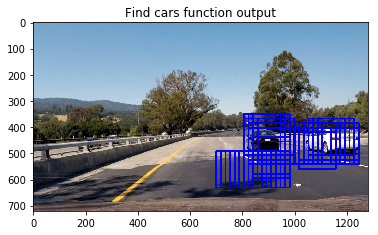

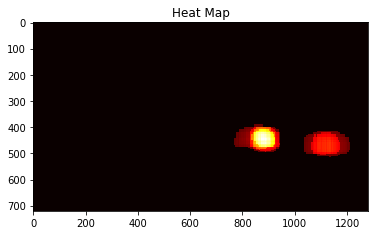

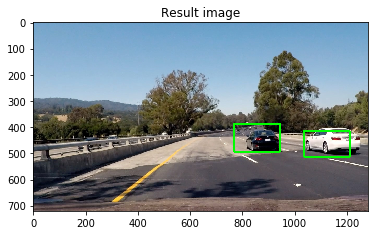

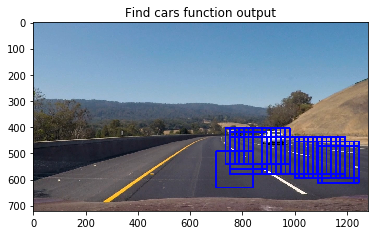

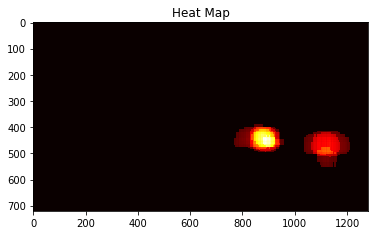

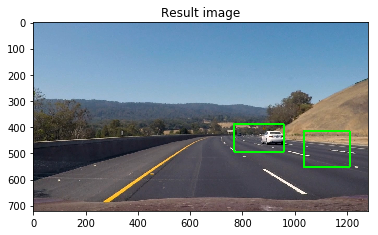

In [8]:
def pipline_test(image):
    '''
    takes an image and returns a image
    
    '''
    #initialize for heatmap of current frame
    heat_sframe = np.zeros_like(image[:,:,0]).astype(np.float)
    #initialize hot_windows recoder
    buffer.hot_windows = []
    threshold = 50
    
    for idx ,scale in enumerate(sliding_window['scale']):
        ystart = sliding_window['ystart'][idx]
        ystop = sliding_window['ystop'][idx]
        cells_per_step = sliding_window['cells_per_step'][idx]
        out_img = find_cars(image,ystart,ystop,cells_per_step,scale,svc,X_scaler,color_space,orient,
                           pix_per_cell,cell_per_block,spatial_feat,spatial_size,hist_feat,hist_bins)  
    plt.imshow(out_img)
    plt.title('Find cars function output')
    plt.show()
    #Add heat to each box in box list
    #print(buffer.hot_windows)
    heat_sframe = add_heat(heat_sframe,buffer.hot_windows)
    
    heat_sframe = apply_threshold(heat_sframe,threshold)
    
    buffer.update_heat_historic(heat_sframe)
    
    smooth_heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    for h in buffer.heat_mframe:
        smooth_heat +=h
    
    smooth_heat = smooth_heat/len(buffer.heat_mframe)
    heatmap = np.clip(smooth_heat,0,255)

    plt.imshow(heatmap,cmap='hot')
    plt.title('Heat Map')
    plt.show()
    
    labels = label(heatmap)
    new = draw_labeled_bboxes(np.copy(image),labels)
    plt.imshow(new)
    plt.title('Result image')
    plt.show()
    return new
# Read test image
test_data = glob.glob('test_images/*.jpg')
for file in test_data:
    image = mpimg.imread(file)
    new_image = pipline_test(image)

In [9]:
#接下来实现 vehicle detector pipeline

def pipline(image):
    '''
    takes an image and returns a image
    
    '''
    #initialize for heatmap of current frame
    heat_sframe = np.zeros_like(image[:,:,0]).astype(np.float)
    #initialize hot_windows recoder
    buffer.hot_windows = []
    threshold = 50
    
    for idx ,scale in enumerate(sliding_window['scale']):
        ystart = sliding_window['ystart'][idx]
        ystop = sliding_window['ystop'][idx]
        cells_per_step = sliding_window['cells_per_step'][idx]
        out_img = find_cars(image,ystart,ystop,cells_per_step,scale,svc,X_scaler,color_space,orient,
                           pix_per_cell,cell_per_block,spatial_feat,spatial_size,hist_feat,hist_bins)
        
    heat_sframe = add_heat(heat_sframe,buffer.hot_windows)
    
    heat_sframe = apply_threshold(heat_sframe,threshold)
    
    buffer.update_heat_historic(heat_sframe)
    
    smooth_heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    for h in buffer.heat_mframe:
        smooth_heat +=h
    
    smooth_heat = smooth_heat/len(buffer.heat_mframe)
    heatmap = np.clip(smooth_heat,0,255)
    
    labels = label(heatmap)
    new = draw_labeled_bboxes(np.copy(image),labels)
    return new

In [10]:
# Run pipeline on video
video_output = 'project_solution.mp4'
clip1 = VideoFileClip('project_video.mp4')
white_clip = clip1.fl_image(pipline)
%time white_clip.write_videofile(video_output,audio=False)

[MoviePy] >>>> Building video project_solution.mp4
[MoviePy] Writing video project_solution.mp4


100%|█████████▉| 1260/1261 [12:31<00:00,  1.70it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_solution.mp4 

CPU times: user 12min 32s, sys: 2.17 s, total: 12min 34s
Wall time: 12min 32s
